In [1]:
import torch

In [2]:
from comet_ml import Experiment, Optimizer

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [4]:
import node

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [6]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
from sklearn.metrics import classification_report, balanced_accuracy_score

In [8]:
import pyhopper

In [9]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [10]:
import seaborn as sns

In [11]:
DEVICE="cuda:0"

In [12]:
from loguru import logger

logger.add("log_.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

2

# Load data

In [13]:
DATA = "Libras"

In [14]:
if DATA == "Ionosphere":
    ionosphere = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data', header=None)
    ionosphere = ionosphere.drop(1, axis=1)
    X = ionosphere.values[:, :-1].astype(float)
    y = ionosphere.values[:, -1]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(351, 33) 2 
    GS_METRIC = "balanced_accuracy"
    
elif DATA == "Libras":
    libras = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data', header=None)
    X = libras.values[:, :-1].astype(float)
    y = libras.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    #(360, 90) 15
    GS_METRIC = "balanced_accuracy"
    
elif DATA == "Lymphography":
    lymphography = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data', header=None)
    X = lymphography.values[:, 1:].astype(float)
    y = lymphography.values[:, 0].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    #(148, 18) 4
    GS_METRIC = "balanced_accuracy"
    
print(X.shape, len(np.unique(y)))


(360, 90) 15


In [15]:
n_classes = len(np.unique(y))
n_classes

15

In [16]:
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

{0: 24, 1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24, 10: 24, 11: 24, 12: 24, 13: 24, 14: 24}


In [17]:
n_features = X.shape[1]
n_features

90

In [18]:
max_size = int(len(X)*0.7)

In [19]:
print('dataset size:', len(X), '|', 'max training size:', max_size)

dataset size: 360 | max training size: 251


In [20]:
TEST_RUN = False

# Preprocess

In [21]:
import imblearn
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [22]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=max_size)

## Benchmark

In [23]:
criterion = torch.nn.CrossEntropyLoss()

In [24]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "roc_auc",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 1
        
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        print('iter', i+1, 'of', iters)
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))
        
        del model
        torch.cuda.empty_cache()

    dframe = pd.DataFrame.from_dict(results)
#     sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### Param search

In [25]:
# def grid_search_best_params(model_fn, param_grid, data_size=max_size, scoring=GS_METRIC):
#     if TEST_RUN:
#         tmp = {k: [v[0]] for k, v in param_grid.items()}
#         param_grid = tmp
        
#     X_train, X_test, y_train, y_test = prepare_data(X, y, data_size)

#     cv_clf = GridSearchCV(
#         estimator=model_fn(), 
#         param_grid=param_grid,
#         scoring=scoring, 
#         return_train_score=True,
#         verbose=1, 
#         cv=5,
#     )

#     res = cv_clf.fit(X_train, y_train)

#     print(f'best params for {DATA}', res.best_params_)
#     print('mean_train_score', cv_clf.cv_results_['mean_train_score'].mean())
#     print('std_train_score', cv_clf.cv_results_['std_train_score'].mean())

#     predictions = cv_clf.predict(X_test) 
#     print(classification_report(y_test, predictions))
    
#     with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
#             f.write(str(res.best_params_) + ", " + str(balanced_accuracy_score(y_test, predictions)) + "\n")
    
#     print(f"{DATA}_{model_fn.__name__}_{res.best_params_}")
    
#     return res.best_params_

In [62]:
def pyhopper_best_params(model_fn, param_grid, data_size=GS_DATA_SIZE, metric=GS_METRIC, time="30m", default_params={}, n_jobs=1):
    if TEST_RUN:
        time = 30
        if 'epochs' in param_grid:
            param_grid["epochs"] = pyhopper.choice([10])
        
    logger.info(f"pyhopper_best_params {model_fn.__name__}")
    
    def objective(params):
        torch.cuda.empty_cache()

        model_results = test_model(
                        model_fn(
                            **default_params,
                            **params
                        ),
                        (X, y),
                        data_size,
                        None, 5)
        with open(f"{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(datetime.datetime.now()) + ", " + str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, n_jobs=n_jobs, seeding_ratio=0.5)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params, search.history


# TRAIN MODELS

### XGBoost

In [52]:
from xgboost import XGBClassifier

In [53]:
import xgboost
xgboost.__version__

'1.6.0'

In [54]:
def get_xgboost(**params):
    random_seed = np.random.randint(1024)
    def _inner(**args):
        return XGBClassifier(
            verbosity=0,
            random_state=random_seed,
            use_label_encoder=False,
            **params,
            **args
        )
    return _inner    

#### Hyperparam tuning

2022-11-14 23:32:06.483 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params get_xgboost


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter

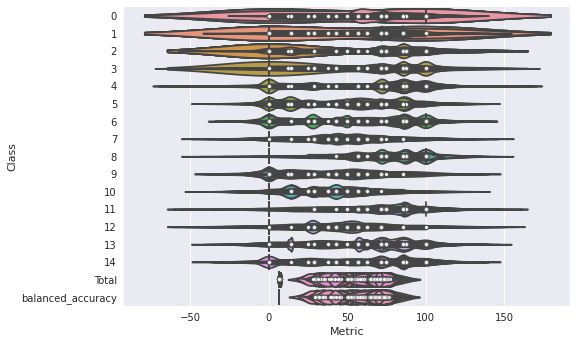

In [30]:
param_grid = {
                'n_estimators': pyhopper.int(50, 1500, multiple_of=50),
                'max_depth': pyhopper.choice([2, 3, 5, 10, 15]),
                'learning_rate': pyhopper.float(1e-5,1e-1, log=True),
                'min_child_weight': pyhopper.choice([1, 2, 4, 8, 16, 32]),
                'gamma': pyhopper.choice([0, 0.001, 0.1, 1]),
             }

xgbt_best1 = pyhopper_best_params(get_xgboost, param_grid, time="90m")

2022-11-15 01:03:39.618 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params get_xgboost


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter

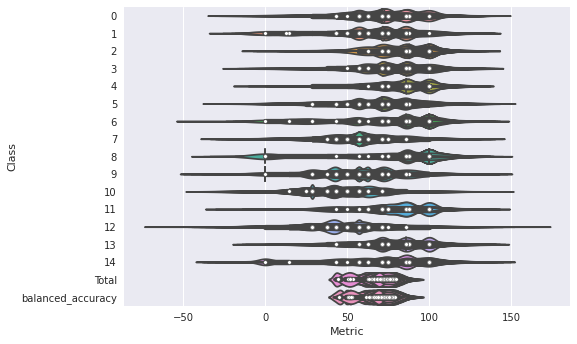

In [31]:
param_grid = {
                'subsample': pyhopper.choice([0.5, 0.6, 0.7, 0.8, 0.9, 1]),
                'reg_lambda': pyhopper.float(1e-5, 10, init=0, log=True),
                'reg_alpha': pyhopper.float(1e-5, 10, init=0, log=True),
             }


xgbt_best2 = pyhopper_best_params(get_xgboost, param_grid, time="90m", default_params=xgbt_best1)

#### Best Params

'Ionosphere' {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1500}


In [32]:
xgboost_best = {**xgbt_best1, **xgbt_best2}

In [55]:
data_size = max_size

xgb_dframe = test_model(get_xgboost(**xgboost_best),
                        (X, y),
                        data_size,
                        label_encoder=None, iters=10)

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


In [34]:
res = xgb_dframe[xgb_dframe["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

251: 74.40 ~ 4.62 (max: 83.49)


In [56]:
xgb_dframe.groupby(['Class']).mean()

,Metric
Class,
0,60.714286
1,49.821429
2,83.928571
3,71.607143
4,85.535714
5,60.892857
6,63.035714
7,54.464286
8,72.142857


### NODE

In [36]:
from qhoptim.pyt import QHAdam

In [63]:
def node_fn(layer_dim=128, num_layers=1, depth=3):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], 
                            layer_dim=layer_dim,
                            num_layers=num_layers, 
                            tree_dim=n_classes+1, 
                            depth=depth, 
                            flatten_output=False,
                            choice_function=node.entmax15, 
                            bin_function=node.entmoid15
                           ),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        
        network = network.to(DEVICE)
        network.device=DEVICE
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train, device=DEVICE).to(torch.float32))
        
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

#### Tune hyperparams

In [64]:
# 'layer_dim': hp.quniform('layer_dim', 100, 1200, 100),
# 'num_layers': hp.quniform('num_layers', 1, 4, 1),
# 'depth': hp.quniform('depth', 2, 7, 1)
                    
param_grid = {
    'layer_dim': pyhopper.int(64, 1024, power_of=2),
    'num_layers': pyhopper.int(1, 5),
    'depth': pyhopper.int(2, 7),
}

node_best = pyhopper_best_params(node_fn, param_grid, time="90m")
node_best

2022-11-15 13:43:30.042 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params node_fn


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 1 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 2 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 3 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 4 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


iter 5 of 5


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 79.76  : 1     : 05:27 (m:s)     
Random seeding    : 81.36  : 8     : 49:28 (m:s)     
Local sampling    : 83.43  : 8     : 35:33 (m:s)     
Duplicates        : -      : 7     : -               
----------------  : ----   : ----  : ----            
Total             : 83.43  : 24    : 01:30:28 (h:m:s)
Libras_node_fn_{'layer_dim': 256, 'num_layers': 4, 'depth': 5}


{'layer_dim': 256, 'num_layers': 4, 'depth': 5}

In [65]:
torch.cuda.memory_reserved()

0

#### Use best hyperparams

In [66]:
%%capture --no-stdout

size=max_size

node_results = test_model(node_fn(**node_best),
                    (X, y),
                    size,
                    label_encoder=None, iters=20)
res = node_results[node_results["Class"]=="roc_auc"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

iter 1 of 20
iter 2 of 20
iter 3 of 20
iter 4 of 20
iter 5 of 20
iter 6 of 20
iter 7 of 20
iter 8 of 20
iter 9 of 20
iter 10 of 20
iter 11 of 20
iter 12 of 20
iter 13 of 20
iter 14 of 20
iter 15 of 20
iter 16 of 20
iter 17 of 20
iter 18 of 20
iter 19 of 20
iter 20 of 20
251: nan ~ nan, (max: nan)


### Dropout Neural network

In [67]:
def network_fn1(epochs=100, drop1=0.3, drop2=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(128, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn2(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(128, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(128, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn3(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, drop4=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(128, 256),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(256, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop4),
                        torch.nn.Linear(128, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner

#### Find Hyperparams

### Dropout 1 layer

In [68]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn1_best_params = pyhopper_best_params(network_fn1, param_grid, time="60m")
nn_fn1_best_params

2022-11-15 16:09:06.802 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params network_fn1


  0%|          | [00:00<?]

Search is scheduled for 01:00:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5

{'epochs': 150, 'drop1': 0.1, 'drop2': 0.5, 'lr': 0.0003, 'batch_size': 32}

In [69]:
data_size = max_size

nn1_results = test_model(network_fn1(**nn_fn1_best_params),
                (X, y),
                data_size,
                None, 20)

iter 1 of 20
iter 2 of 20
iter 3 of 20
iter 4 of 20
iter 5 of 20
iter 6 of 20
iter 7 of 20
iter 8 of 20
iter 9 of 20
iter 10 of 20
iter 11 of 20
iter 12 of 20
iter 13 of 20
iter 14 of 20
iter 15 of 20
iter 16 of 20
iter 17 of 20
iter 18 of 20
iter 19 of 20
iter 20 of 20


In [70]:
res = nn1_results[nn1_results["Class"]=="Balanced Acc score"]["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

251: nan ~ nan (max: nan)


### Dropout 2 layers

In [71]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn2_best_params = pyhopper_best_params(network_fn2, param_grid, time="70m")
nn_fn2_best_params

2022-11-15 17:18:13.796 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params network_fn2


  0%|          | [00:00<?]

Search is scheduled for 01:10:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

{'epochs': 150,
 'drop1': 0.1,
 'drop2': 0.3,
 'drop3': 0.1,
 'lr': 0.003,
 'batch_size': 32}

In [72]:
data_size = max_size

nn2_results = test_model(network_fn2(**nn_fn2_best_params),
                (X, y),
                data_size,
                None, 20)

iter 1 of 20
iter 2 of 20
iter 3 of 20
iter 4 of 20
iter 5 of 20
iter 6 of 20
iter 7 of 20
iter 8 of 20
iter 9 of 20
iter 10 of 20
iter 11 of 20
iter 12 of 20
iter 13 of 20
iter 14 of 20
iter 15 of 20
iter 16 of 20
iter 17 of 20
iter 18 of 20
iter 19 of 20
iter 20 of 20


### Dropout 3 layers

In [73]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop4": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn3_best_params = pyhopper_best_params(network_fn3, param_grid, time="75m")
nn_fn3_best_params

2022-11-15 18:38:01.138 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params network_fn3


  0%|          | [00:00<?]

Search is scheduled for 01:15:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

{'epochs': 150,
 'drop1': 0.1,
 'drop2': 0.1,
 'drop3': 0.1,
 'drop4': 0.1,
 'lr': 0.0003,
 'batch_size': 64}

In [74]:
data_size = max_size

nn3_results = test_model(network_fn3(**nn_fn3_best_params),
                (X, y),
                data_size,
                None, 20)

iter 1 of 20
iter 2 of 20
iter 3 of 20
iter 4 of 20
iter 5 of 20
iter 6 of 20
iter 7 of 20
iter 8 of 20
iter 9 of 20
iter 10 of 20
iter 11 of 20
iter 12 of 20
iter 13 of 20
iter 14 of 20
iter 15 of 20
iter 16 of 20


### HypernetworkPCA

In [75]:
def network_pca_fn(epochs=100, masks_no=100, mask_size=100, target_size=100, n_comp=5, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_comp, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 256),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=n_features
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

In [76]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

In [77]:
X.shape[1] // 7

12

#### Find hyperparams

In [89]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(40, 110, multiple_of=10),
    "mask_size": pyhopper.int(5, 70),
    "target_size": pyhopper.choice([5, 10, 20, 50, 100, 150]),
    "n_comp": pyhopper.int(5, 40),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),

}

hp_pca_best_params = pyhopper_best_params(network_pca_fn, param_grid, time="120m")
hp_pca_best_params

2022-11-15 21:14:46.069 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params network_pca_fn


  0%|          | [00:00<?]

Search is scheduled for 02:00:00 (h:m:s)
iter 1 of 5
torch.Size([1, 256])
90
iter 2 of 5
torch.Size([1, 256])
90
iter 3 of 5
torch.Size([1, 256])
90
iter 4 of 5
torch.Size([1, 256])
90
iter 5 of 5
torch.Size([1, 256])
90
iter 1 of 5
torch.Size([1, 256])
90
iter 2 of 5
torch.Size([1, 256])
90
iter 3 of 5
torch.Size([1, 256])
90
iter 4 of 5
torch.Size([1, 256])
90
iter 5 of 5
torch.Size([1, 256])
90
iter 1 of 5
torch.Size([1, 256])
90
iter 2 of 5
torch.Size([1, 256])
90
iter 3 of 5
torch.Size([1, 256])
90
iter 4 of 5
torch.Size([1, 256])
90
iter 5 of 5
torch.Size([1, 256])
90
iter 1 of 5
torch.Size([1, 256])
90
iter 2 of 5
torch.Size([1, 256])
90
iter 3 of 5
torch.Size([1, 256])
90
iter 4 of 5
torch.Size([1, 256])
90
iter 5 of 5
torch.Size([1, 256])
90
====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 73.83  : 1     : 19:33 (m:s)     
Random seeding    : 89.

{'epochs': 150,
 'masks_no': 70,
 'mask_size': 30,
 'target_size': 150,
 'n_comp': 10,
 'lr': 0.03,
 'batch_size': 32}

In [90]:
hp_pca_best_params

{'epochs': 150,
 'masks_no': 70,
 'mask_size': 30,
 'target_size': 150,
 'n_comp': 10,
 'lr': 0.03,
 'batch_size': 32}

'Libras'
{'epochs': 150,
 'masks_no': 70,
 'mask_size': 20,
 'target_size': 10,
 'n_comp': 10}

'Lymphography' {'epochs': 120, 'masks_no': 50, 'mask_size': 4, 'target_size': 20, 'n_comp': 6}

In [91]:
DATA

'Libras'

Ionosphere
{'epochs': 100, 'masks_no': 60, 'mask_size': 5, 'target_size': 10}


In [92]:
epochs = hp_pca_best_params['epochs']
masks_no = hp_pca_best_params['masks_no']
mask_size = hp_pca_best_params['mask_size']
target_size = hp_pca_best_params['target_size']
n_comp = hp_pca_best_params['n_comp']
data_size = max_size

nn_pca_results = test_model(network_pca_fn(target_size=target_size, mask_size=mask_size, masks_no=masks_no, n_comp=n_comp),
                (X, y),
                data_size,
                None, 20)

# exp.log_table("metrics.csv", nn_pca_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_pca_results.groupby("Class").mean().loc["F1 score"])

iter 1 of 20
torch.Size([1, 256])
90
iter 2 of 20
torch.Size([1, 256])
90
iter 3 of 20
torch.Size([1, 256])
90
iter 4 of 20
torch.Size([1, 256])
90
iter 5 of 20
torch.Size([1, 256])
90
iter 6 of 20
torch.Size([1, 256])
90
iter 7 of 20
torch.Size([1, 256])
90
iter 8 of 20
torch.Size([1, 256])
90
iter 9 of 20
torch.Size([1, 256])
90
iter 10 of 20
torch.Size([1, 256])
90
iter 11 of 20
torch.Size([1, 256])
90
iter 12 of 20
torch.Size([1, 256])
90
iter 13 of 20
torch.Size([1, 256])
90
iter 14 of 20
torch.Size([1, 256])
90
iter 15 of 20
torch.Size([1, 256])
90
iter 16 of 20
torch.Size([1, 256])
90
iter 17 of 20
torch.Size([1, 256])
90
iter 18 of 20
torch.Size([1, 256])
90
iter 19 of 20
torch.Size([1, 256])
90
iter 20 of 20
torch.Size([1, 256])
90


In [93]:
res = nn_pca_results[nn_pca_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

251: 86.33 ~ 2.36 (max: 90.83)


### Hypernetwork

In [94]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 128), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 256),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

#### Find hyperparams

In [95]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(10, 100, multiple_of=10),
    "mask_size": pyhopper.int(5, 70),
    "target_size": pyhopper.choice([5, 10, 20, 50, 100, 150]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(network_hp_fn, param_grid, time="120m")
hp_best_params

2022-11-15 23:45:18.176 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params network_hp_fn


  0%|          | [00:00<?]

Search is scheduled for 02:00:00 (h:m:s)
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
iter 5 of 5
torch.Size([1, 256])
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
iter 5 of 5
torch.Size([1, 256])
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
iter 5 of 5
torch.Size([1, 256])
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
iter 5 of 5
torch.Size([1, 256])
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
iter 5 of 5
torch.Size([1, 256])
iter 1 of 5
torch.Size([1, 256])
iter 2 of 5
torch.Size([1, 256])
iter 3 of 5
torch.Size([1, 256])
iter 4 of 5
torch.Size([1, 256])
it

{'epochs': 100,
 'masks_no': 70,
 'mask_size': 61,
 'target_size': 100,
 'lr': 3e-05,
 'batch_size': 32}

#### Train using the best hyperparams

In [96]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
data_size = max_size

hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    data_size,
                    None, 20)

iter 1 of 20
torch.Size([1, 256])
iter 2 of 20
torch.Size([1, 256])
iter 3 of 20
torch.Size([1, 256])
iter 4 of 20
torch.Size([1, 256])
iter 5 of 20
torch.Size([1, 256])
iter 6 of 20
torch.Size([1, 256])
iter 7 of 20
torch.Size([1, 256])
iter 8 of 20
torch.Size([1, 256])
iter 9 of 20
torch.Size([1, 256])
iter 10 of 20
torch.Size([1, 256])
iter 11 of 20
torch.Size([1, 256])
iter 13 of 20
torch.Size([1, 256])
iter 14 of 20
torch.Size([1, 256])
iter 15 of 20
torch.Size([1, 256])
iter 16 of 20
torch.Size([1, 256])
iter 17 of 20
torch.Size([1, 256])
iter 18 of 20
torch.Size([1, 256])
iter 19 of 20
torch.Size([1, 256])
iter 20 of 20
torch.Size([1, 256])


In [97]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

251: 85.18 ~ 2.86, (max: 89.91)


### Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
def get_rf(**params):
    random_seed = np.random.randint(1024)
    def _inner():
        return RandomForestClassifier(
            random_state=random_seed,
            **params
        )
    return _inner

#### Find hyperparams

In [100]:
param_grid = {
                'n_estimators': pyhopper.int(50, 3000, multiple_of=50),
                'max_features': pyhopper.choice([None, 'sqrt', 0.2, 0.3, 0.5, 0.7]),
                'criterion' : pyhopper.choice(['gini', 'entropy']),
                'max_depth': pyhopper.choice([None, 2, 4, 8, 16]),
             }

rf_best = pyhopper_best_params(get_rf, param_grid, time="90m")
rf_best

2022-11-16 02:07:55.292 | INFO     | __main__:pyhopper_best_params:5 - pyhopper_best_params get_rf


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5

{'n_estimators': 2700,
 'max_features': None,
 'criterion': 'gini',
 'max_depth': 16}

#### Use best params

In [47]:
#TMP

rf_best = {'n_estimators': 3500, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': None}


In [48]:
size = max_size

rf_dframe = test_model(get_rf(**rf_best), 
                        (X, y),
                        size,
                        None, iters=10)

iter 1 of 10
iter 2 of 10
iter 3 of 10
iter 4 of 10
iter 5 of 10
iter 6 of 10
iter 7 of 10
iter 8 of 10
iter 9 of 10
iter 10 of 10


In [49]:
rf_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

,mean,std,max
Class,,,
0,80.178571,12.153648,100.000000
1,80.178571,13.766610,100.000000
2,95.892857,6.630963,100.000000
3,82.142857,17.189916,100.000000
4,88.750000,14.726580,100.000000
5,77.678571,13.812859,100.000000
6,90.714286,13.826959,100.000000
7,51.607143,12.998833,75.000000
8,100.000000,0.000000,100.000000


# Collect analytics

In [102]:
d = {}

In [103]:
d['Random forest'] = rf_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Hypernet'] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['HypernetPCA'] = nn_pca_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_1'] = nn1_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_2'] = nn2_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_3'] = nn3_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Node'] = node_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['XGBoost'] = xgb_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

In [104]:
all_models_df=pd.concat(d, axis=0)
all_models_df

mean        std         max
              Class                                              
Random forest 0                  82.142857  10.635677  100.000000
              1                  77.410714  17.306113  100.000000
              2                  94.464286   8.373738  100.000000
              3                  83.214286  18.812775  100.000000
              4                  87.232143  13.992227  100.000000
...                                    ...        ...         ...
XGBoost       12                 48.928571  20.330579   85.714286
              13                 80.892857  17.236391  100.000000
              14                 81.071429  13.849060  100.000000
              Total              74.403670   4.619874   83.486239
              balanced_accuracy  74.375000   4.552553   83.452381

[136 rows x 3 columns]

In [105]:
all_models_df.to_csv(f"{DATA}_metrics.csv")

In [ ]:
os.environ['COMET_KEY']

In [107]:
os.environ.get("COMET_KEY")

'UXrV5UxyhTK3cyQNG6BDuc4bE'

In [108]:
exp = Experiment(os.environ.get("COMET_KEY"), 'hypernet-uci-tune')
# exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no, "data_size": data_size})
exp.add_tag(f"hypernet-tune2{DATA}")
exp.log_table(f"{DATA}_metrics.csv", all_models_df)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/abulenok/hypernet-uci-tune/3bc1bbf39d0f44279027223ed35f43eb



{'web': 'https://www.comet.com/api/asset/download?assetId=b1025f15ce7646f5ad5c8bd28aa16ca5&experimentKey=3bc1bbf39d0f44279027223ed35f43eb',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b1025f15ce7646f5ad5c8bd28aa16ca5&experimentKey=3bc1bbf39d0f44279027223ed35f43eb',
 'assetId': 'b1025f15ce7646f5ad5c8bd28aa16ca5'}

In [ ]:
f"{DATA}_metrics.csv"

In [ ]:
# all_models_df = pd.read_csv(f"{DATA}_metrics.csv")

In [110]:
all_models_df

mean        std         max
              Class                                              
Random forest 0                  82.142857  10.635677  100.000000
              1                  77.410714  17.306113  100.000000
              2                  94.464286   8.373738  100.000000
              3                  83.214286  18.812775  100.000000
              4                  87.232143  13.992227  100.000000
...                                    ...        ...         ...
XGBoost       12                 48.928571  20.330579   85.714286
              13                 80.892857  17.236391  100.000000
              14                 81.071429  13.849060  100.000000
              Total              74.403670   4.619874   83.486239
              balanced_accuracy  74.375000   4.552553   83.452381

[136 rows x 3 columns]

In [112]:
tmp = all_models_df.reset_index()

In [113]:
tmp = tmp.rename(columns={tmp.columns[0]: DATA})

In [114]:
tmp[tmp['Class'] == "balanced_accuracy"]

,Libras,Class,mean,std,max
16,Random forest,balanced_accuracy,77.422619,3.876155,85.357143
33,Hypernet,balanced_accuracy,85.220238,2.927617,90.000000
50,HypernetPCA,balanced_accuracy,86.470238,2.411234,91.071429
67,Dropout_1,balanced_accuracy,78.125000,3.618090,83.333333
84,Dropout_2,balanced_accuracy,81.398810,3.422953,87.738095
101,Dropout_3,balanced_accuracy,81.541667,3.985495,87.738095
118,Node,balanced_accuracy,82.720238,3.274015,88.095238
135,XGBoost,balanced_accuracy,74.375000,4.552553,83.452381
